<a href="https://colab.research.google.com/github/BraneXZ/CNN_Cifar10_with_InceptionV4/blob/master/Cifar10_with_InceptionV4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# tensorflow 2.0 beta and tensorflow datasets
!pip install tensorflow-gpu==2.0.0-beta1
!pip install tensorflow-datasets

# tenorflow
import tensorflow as     tf
from   tensorflow import keras

# tensorflow datasets
import tensorflow_datasets as tfds

# additional libraries
import math
import numpy             as np
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# data
DATA_NUM_CLASSES        = 10
DATA_CHANNELS           = 3
DATA_ROWS               = 32
DATA_COLS               = 32
DATA_CROP_ROWS          = 28
DATA_CROP_COLS          = 28
DATA_MEAN               = np.array([[[125.30691805, 122.95039414, 113.86538318]]]) # CIFAR10
DATA_STD_DEV            = np.array([[[ 62.99321928,  62.08870764,  66.70489964]]]) # CIFAR10

# model
INCEPTION_A    = 3
INCEPTION_B    = 7
INCEPTION_C    = 4

# training
TRAINING_BATCH_SIZE      = 32
TRAINING_SHUFFLE_BUFFER  = 5000
TRAINING_BN_MOMENTUM     = 0.99
TRAINING_BN_EPSILON      = 0.001
TRAINING_LR_MAX          = 0.001
# TRAINING_LR_SCALE        = 0.1
# TRAINING_LR_EPOCHS       = 2
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 55

# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# saving
SAVE_MODEL_PATH = '/content/drive/My Drive/save/model_long/'
!mkdir -p "$SAVE_MODEL_PATH"


In [0]:
# pre processing for training data
def pre_processing_train(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]
  
    # image is cast to float32, normalized, augmented and random cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[DATA_CROP_ROWS, DATA_CROP_COLS, 3])
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# pre processing for testing data
def pre_processing_test(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]

    # image is cast to float32, normalized, augmented and center cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.crop_to_bounding_box(image, (DATA_ROWS - DATA_CROP_ROWS) // 2, (DATA_COLS - DATA_CROP_COLS) // 2, DATA_CROP_ROWS, DATA_CROP_COLS)
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

In [0]:
# download data and split into training and testing datasets
dataset_train, info = tfds.load("cifar10", split=tfds.Split.TRAIN, with_info=True)
dataset_test,  info = tfds.load("cifar10", split=tfds.Split.TEST,  with_info=True)

In [0]:
# transform training dataset
dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=4)
dataset_train = dataset_train.shuffle(buffer_size=TRAINING_SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(TRAINING_BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=1)

# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=4)
dataset_test = dataset_test.batch(TRAINING_BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=1)


In [0]:
def create_model(rows, cols, channels, num_classes, lr_initial):
  # encoder - input
  model_input = keras.Input(shape=(rows, cols, channels), name='input_image')
  x           = model_input

  # encoder - tail
  x = keras.layers.Conv2D(4, 3, strides=1, padding="same", activation=None, use_bias=False)(x)

  # Inception A
  for i in range (INCEPTION_A):
    residual1 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual1 = keras.layers.ReLU()(residual1)
    residual1 = keras.layers.AveragePooling2D(strides=1, padding="same")(residual1)
    residual1 = keras.layers.Conv2D(12, 1, strides=1, padding="same", activation=None, use_bias=False)(residual1)
    
    residual2 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual2 = keras.layers.ReLU()(residual2)
    residual2 = keras.layers.Conv2D(12, 1, strides=1, padding="same", activation=None, use_bias=False)(residual2)
    
    residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual3 = keras.layers.ReLU()(residual3)
    residual3 = keras.layers.Conv2D(8, 1, strides=1, padding="same", activation=None, use_bias=False)(residual3)
    residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual3)
    residual3 = keras.layers.ReLU()(residual3)
    residual3 = keras.layers.Conv2D(12, 3, strides=1, padding="same", activation=None, use_bias=False)(residual3)
    
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(8, 1, strides=1, padding="same", activation=None, use_bias=False)(residual4)
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual4)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(12, 3, strides=1, padding="same", activation=None, use_bias=False)(residual4)
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual4)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(12, 3, strides=1, padding="same", activation=None, use_bias=False)(residual4)
    
    x = keras.layers.Concatenate()([residual1, residual2, residual3, residual4])
  
  # Reduction A
  residual1 = keras.layers.MaxPooling2D(3, strides=2, padding="valid")(x)
  
  residual2 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
  residual2 = keras.layers.ReLU()(residual2)
  residual2 = keras.layers.Conv2D(48, 3, strides=2, padding="valid", activation=None, use_bias=False)(residual2)
  
  residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
  residual3 = keras.layers.ReLU()(residual3)
  residual3 = keras.layers.Conv2D(24, 1, strides=1, padding="same", activation=None, use_bias=False)(residual3)
  residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
  residual3 = keras.layers.ReLU()(residual3)
  residual3 = keras.layers.Conv2D(28, 3, strides=1, padding="same", activation=None, use_bias=False)(residual3)
  residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
  residual3 = keras.layers.ReLU()(residual3)
  residual3 = keras.layers.Conv2D(32, 3, strides=2, padding="valid", activation=None, use_bias=False)(residual3)
  
  x = keras.layers.Concatenate()([residual1, residual2, residual3])

  # Inception B
  for i in range (INCEPTION_B):
    residual1 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual1 = keras.layers.ReLU()(residual1)
    residual1 = keras.layers.AveragePooling2D(strides=1, padding="same")(residual1)
    residual1 = keras.layers.Conv2D(16, 1, strides=1, padding="same", activation=None, use_bias=False)(residual1)
    
    residual2 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual2 = keras.layers.ReLU()(residual2)
    residual2 = keras.layers.Conv2D(48, 1, strides=1, padding="same", activation=None, use_bias=False)(residual2)
    
    residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual3 = keras.layers.ReLU()(residual3)
    residual3 = keras.layers.Conv2D(24, 1, strides=1, padding="same", activation=None, use_bias=False)(residual3)
    residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual3)
    residual3 = keras.layers.ReLU()(residual3)
    residual3 = keras.layers.Conv2D(28, (1, 7), strides=1, padding="same", activation=None, use_bias=False)(residual3)
    residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual3)
    residual3 = keras.layers.ReLU()(residual3)
    residual3 = keras.layers.Conv2D(32, (1, 7), strides=1, padding="same", activation=None, use_bias=False)(residual3)
    
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(24, 1, strides=1, padding="same", activation=None, use_bias=False)(residual4)
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual4)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(24, (1, 7), strides=1, padding="same", activation=None, use_bias=False)(residual4)
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual4)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(28, (7, 1), strides=1, padding="same", activation=None, use_bias=False)(residual4)
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual4)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(28, (1, 7), strides=1, padding="same", activation=None, use_bias=False)(residual4)
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual4)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(32, (7, 1), strides=1, padding="same", activation=None, use_bias=False)(residual4)
    
    x = keras.layers.Concatenate()([residual1, residual2, residual3, residual4])
    
  # Reduction B
  residual1 = keras.layers.MaxPooling2D(3, strides=2, padding="valid")(x)
  
  residual2 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
  residual2 = keras.layers.ReLU()(residual2)
  residual2 = keras.layers.Conv2D(24, 1, strides=1, padding="same", activation=None, use_bias=False)(residual2)
  residual2 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual2)
  residual2 = keras.layers.ReLU()(residual2)
  residual2 = keras.layers.Conv2D(24, 3, strides=2, padding="valid", activation=None, use_bias=False)(residual2)
  
  residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
  residual3 = keras.layers.ReLU()(residual3)
  residual3 = keras.layers.Conv2D(32, 1, strides=1, padding="same", activation=None, use_bias=False)(residual3)
  residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
  residual3 = keras.layers.ReLU()(residual3)
  residual3 = keras.layers.Conv2D(32, (1, 7), strides=1, padding="same", activation=None, use_bias=False)(residual3)
  residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
  residual3 = keras.layers.ReLU()(residual3)
  residual3 = keras.layers.Conv2D(40, (7, 1), strides=1, padding="same", activation=None, use_bias=False)(residual3)
  residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
  residual3 = keras.layers.ReLU()(residual3)
  residual3 = keras.layers.Conv2D(40, 3, strides=2, padding="valid", activation=None, use_bias=False)(residual3)
  
  x = keras.layers.Concatenate()([residual1, residual2, residual3])
  

  # Inception C
  for i in range (INCEPTION_C):
    residual1 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual1 = keras.layers.ReLU()(residual1)
    residual1 = keras.layers.AveragePooling2D(strides=1, padding="same")(residual1)
    residual1 = keras.layers.Conv2D(32, 1, strides=1, padding="same", activation=None, use_bias=False)(residual1)
    
    residual2 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual2 = keras.layers.ReLU()(residual2)
    residual2 = keras.layers.Conv2D(32, 1, strides=1, padding="same", activation=None, use_bias=False)(residual2)
    
    residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual3 = keras.layers.ReLU()(residual3)
    residual3 = keras.layers.Conv2D(48, 1, strides=1, padding="same", activation=None, use_bias=False)(residual3)
    residual3 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual3)
    residual3 = keras.layers.ReLU()(residual3)
    residual3_1 = keras.layers.Conv2D(32, (1, 3), strides=1, padding="same", activation=None, use_bias=False)(residual3)
    residual3_2 = keras.layers.Conv2D(32, (3, 1), strides=1, padding="same", activation=None, use_bias=False)(residual3)
    
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(48, 1, strides=1, padding="same", activation=None, use_bias=False)(residual4)
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual4)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(56, (1, 3), strides=1, padding="same", activation=None, use_bias=False)(residual4)
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual4)
    residual4 = keras.layers.ReLU()(residual4)
    residual4 = keras.layers.Conv2D(64, (3, 1), strides=1, padding="same", activation=None, use_bias=False)(residual4)
    residual4 = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual4)
    residual4 = keras.layers.ReLU()(residual4)
    residual4_1 = keras.layers.Conv2D(32, (1, 3), strides=1, padding="same", activation=None, use_bias=False)(residual4)
    residual4_2 = keras.layers.Conv2D(32, (3, 1), strides=1, padding="same", activation=None, use_bias=False)(residual4)
    
    x = keras.layers.Concatenate()([residual1, residual2, residual3_1, residual3_2, residual4_1, residual4_2])
  
  x = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
  x = keras.layers.ReLU()(x)
  
  #encoder - output
  encoder_output = x
  
  y = keras.layers.GlobalAveragePooling2D()(encoder_output)
  y = keras.layers.Dropout(0.2)(y)
  decoder_output = keras.layers.Dense(num_classes, activation='softmax')(y)

  # forward path
  model = keras.Model(inputs=model_input, outputs=decoder_output, name='inceptionV4_model')

  # loss, backward path (implicit) and weight update
  model.compile(optimizer=tf.keras.optimizers.Adam(lr_initial), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # return model
  return model
  

In [0]:
model = create_model(28, 28, 3, DATA_NUM_CLASSES, TRAINING_LR_MAX)

In [0]:
model.summary()


Model: "inceptionV4_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_234 (Conv2D)             (None, 28, 28, 4)    108         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization_228 (BatchN (None, 28, 28, 4)    16          conv2d_234[0][0]                 
__________________________________________________________________________________________________
re_lu_228 (ReLU)                (None, 28, 28, 4)    0           batch_normalization_228[0][0]    
__________________________________________________________________________________

In [0]:
keras.utils.plot_model(model, 'cifar_model.png', show_shapes=True)

In [0]:
# learning rate schedule
def lr_schedule(epoch):

    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)*max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + TRAINING_LR_FINAL

    # debug - learning rate display
    # print(epoch)
    # print(lr)

    return lr

# plot training accuracy and loss curves
def plot_training_curves(history):

    # training and validation data accuracy
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # training and validation data loss
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # plot loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

Epoch 1/60
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


   1563/Unknown - 201s 128ms/step - loss: 2.3175 - accuracy: 0.1474
Epoch 00001: val_loss improved from inf to 2.10776, saving model to /content/drive/My Drive/save/model/model_1.h5
1563/1563 [==============================] - 211s 135ms/step - loss: 2.3175 - accuracy: 0.1474 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/60
1562/1563 [============================>.] - ETA: 0s - loss: 1.5715 - accuracy: 0.4217
Epoch 00002: val_loss improved from 2.10776 to 1.33636, saving model to /content/drive/My Drive/save/model/model_2.h5
1563/1563 [==============================] - 178s 114ms/step - loss: 1.5714 - accuracy: 0.4217 - val_loss: 1.3364 - val_accuracy: 0.5170
Epoch 3/60
1562/1563 [============================>.] - ETA: 0s - loss: 1.2042 - accuracy: 0.5693
Epoch 00003: val_loss improved from 1.33636 to 1.06584, saving model to /content/drive/My Drive/save/model/model_3.h5
1563/1563 [==============================] - 177s 113ms/step - loss: 1.2041 - accuracy: 0.5693 - val_los

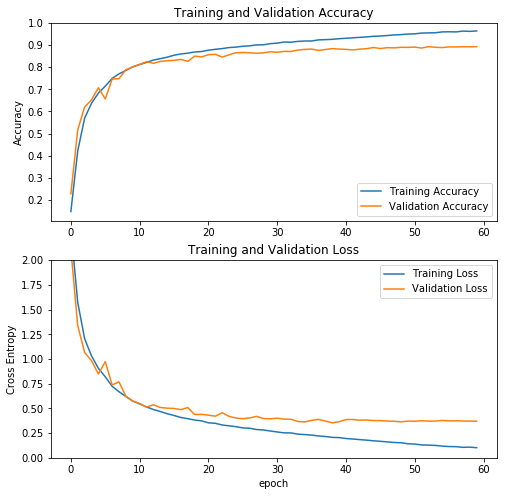

In [0]:
# callbacks (learning rate schedule, model checkpointing during training)
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule),
             keras.callbacks.ModelCheckpoint(filepath=SAVE_MODEL_PATH+'model_{epoch}.h5', save_best_only=True, monitor='val_loss', verbose=1)]

# training
initial_epoch_num = 0
history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# example of restarting training after a crash from the last saved checkpoint
# model             = create_model(MODEL_LEVEL_0_REPEATS, MODEL_LEVEL_1_REPEATS, MODEL_LEVEL_2_REPEATS)
# model.load_weights(SAVE_MODEL_PATH+'model_X.h5') # replace X with the last saved checkpoint number
# initial_epoch_num = X                            # replace X with the last saved checkpoint number
# history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# plot accuracy and loss curves
plot_training_curves(history)

In [0]:
model2 = create_model(28, 28, 3, DATA_NUM_CLASSES, TRAINING_LR_MAX)

In [0]:
# training
initial_epoch_num = 0
history2           = model2.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# example of restarting training after a crash from the last saved checkpoint
# model             = create_model(MODEL_LEVEL_0_REPEATS, MODEL_LEVEL_1_REPEATS, MODEL_LEVEL_2_REPEATS)
# model.load_weights(SAVE_MODEL_PATH+'model_X.h5') # replace X with the last saved checkpoint number
# initial_epoch_num = X                            # replace X with the last saved checkpoint number
# history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# plot accuracy and loss curves
plot_training_curves(history2)

Epoch 1/60
   1563/Unknown - 774s 495ms/step - loss: 2.3368 - accuracy: 0.1169
Epoch 00001: val_loss did not improve from 0.35342
1563/1563 [==============================] - 802s 513ms/step - loss: 2.3368 - accuracy: 0.1169 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/60
1562/1563 [============================>.] - ETA: 0s - loss: 2.1298 - accuracy: 0.2037
Epoch 00002: val_loss did not improve from 0.35342
1563/1563 [==============================] - 510s 326ms/step - loss: 2.1296 - accuracy: 0.2037 - val_loss: 1.9303 - val_accuracy: 0.2816
Epoch 3/60
1562/1563 [============================>.] - ETA: 0s - loss: 1.8209 - accuracy: 0.3197
Epoch 00003: val_loss did not improve from 0.35342
1563/1563 [==============================] - 518s 331ms/step - loss: 1.8207 - accuracy: 0.3197 - val_loss: 1.6319 - val_accuracy: 0.4047
Epoch 4/60
1562/1563 [============================>.] - ETA: 0s - loss: 1.5904 - accuracy: 0.4169
Epoch 00004: val_loss did not improve from 0.35342
1563

KeyboardInterrupt: ignored